In [1]:
from __future__ import division

import os
import pandas as pd                     # library to handle data even from spreadsheets 
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.ticker as mticker

import scipy.integrate as integrate
from scipy import interpolate
from scipy.interpolate import griddata  # useful for not-regular grid points
import scipy.special as bessel
import scipy.optimize as opt
from scipy.optimize import curve_fit

import sys
import pylab
import time
from tqdm.notebook import tqdm

In [2]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1

In [3]:
def plot_cosmetics_single():
    ax = plt.gca()
    ax.tick_params(direction='in', axis='both', which='major', length=6.8, width=1.2, labelsize=18)
    ax.tick_params(direction='in', axis='both', which='minor', length=3.3, width=1.2, labelsize=18)
    ax.xaxis.set_tick_params(pad=7)
    ax.xaxis.labelpad = 5
    ax.yaxis.labelpad = 15
    
    
def plot_cosmetics_multi():
    ax = plt.gca()
    ax.tick_params(direction='in', axis='both', which='major', length=6.8, width=1.2, labelsize=20)
    ax.tick_params(direction='in', axis='both', which='minor', length=3.3, width=1.2, labelsize=20)
    ax.xaxis.set_tick_params(pad=10)
    ax.xaxis.labelpad = 5
    ax.yaxis.labelpad = 10

In [4]:
########################################################
# CONSTANTS: physical constants and conversion factors #
########################################################

pc_mt = 3.0857e+16              
pc_cm = 3.0857e+18              
m_to_pc = pow(pc_mt,-1)         
cm_to_pc = 3.24e-19             
conv_factor_GeV_to_erg = 0.00160218   
conv_factor_erg_to_GeV = 624.151
conv_factor_yr_to_sec = 31.56e+6
conv_GeV_g = 1.78e-24

m_p = 0.939                     # proton mass, in [GeV/c^2]
m_e = 0.000510998918            # electron mass, in [GeV/c^2]
c = 2.99e+10                    # speed of light, in [cm sec^{-1}]
c_pcSec = c * cm_to_pc          # same, in [pc sec^{-1}]

***     
# <center> Plasma parameters

$$
\begin{aligned}
&\bullet \; \; x_c \equiv \left( \frac{6 \rho M_A^2 L_{\mathrm{inj}} v_A}{\eta_0} \right)^{2/3} \\
&\bullet \; \; \rho = n_{\mathrm{ISM}} \cdot m_p, \qquad \eta_0 = 6 \cdot 10^{3} \, \left( \frac{37}{\mathrm{ln} \, \Lambda} \right) \left( \frac{T_{\mathrm{ISM}}}{10^8 \, \mathrm{K}} \right)^{5/2} \frac{\mathrm{g}}{\mathrm{cm \cdot s}} \; \left( \mathrm{Spitzer} \, 1962 \right), \qquad \mathrm{ln} \, \Lambda \equiv \mathrm{ln} \, \left( \frac{b_{\mathrm{max}}}{b_{\mathrm{min}}} \right) \simeq \mathrm{ln} \, \left( \frac{\lambda_D}{b_{\mathrm{min}}} \right), \, b_{\mathrm{min}} \approx 8.63 \cdot 10^{-8} \left( \frac{10^4 \, \mathrm{K}}{T_{\mathrm{ISM}}} \right) \, \mathrm{cm} \\
&\bullet \; \; \lambda_D \approx 0.95 \cdot 10^5 \cdot \left( \frac{T}{10^6 \, \mathrm{K}} \right)^{1/2} \left( \frac{10^{-3} \, \mathrm{cm}^{-3}}{n_{\mathrm{ISM}}} \right)^{1/2} \, \mathrm{cm} \\
&\bullet \; \; \beta = 3.3 \cdot \left( \frac{3 \, \mu\mathrm{G}}{B} \right)^2 \left( \frac{n_{\mathrm{ISM}}}{1 \, \mathrm{cm^{-3}}} \right) \left( \frac{T_{\mathrm{ISM}}}{10^4 \, \mathrm{K}} \right) \\
&\bullet \; \;  v_A = 6.27 \cdot 10^5 \, \left( \frac{B}{3 \, \mu\mathrm{G}} \right) \left( \frac{1 \, \mathrm{cm^{-3}}}{n_{\mathrm{ISM}}} \right)^{1/2} \, \mathrm{cm \cdot s^{-1}}
\end{aligned}
$$
***     

In [5]:
################################
### Environmental parameters ###
################################


gamma_ratio = m_p/m_e
B_field = 10.         # magnetic field, in [muGauss]
n_ISM = 0.1           # density of the environment, in [cm^{-3}]
T_ISM = 5.e3          # in [K]

L_inj = 10.           # in [pc]
M_A = 1.              # Alfvénic Mach Number


#####
v_A = 6.27e5 * (B_field / 3.) * (1. / n_ISM)**(1/2)                       # in [cm sec^{-1}]
v_A_pcSec = v_A * cm_to_pc                                                # in [pc sec^{-1}]
rho = n_ISM * (m_p * conv_GeV_g)
Debye_length = 0.95e5 * (T_ISM / 1.e6)**(1/2) * (1.e-3 / n_ISM)**(1/2)    # in [cm]

b_min = 8.63e-8 * (1.e4 / T_ISM)                                          # in [cm]
ln_Lambda = np.log(Debye_length / b_min)
eta_0 = 6.e3 * (37 / ln_Lambda) * (T_ISM / 1.e8)**(5/2)                   # in [g cm^{-1} s^{-1}]


x_c = ( (6 * rho * M_A**2 * (L_inj*pc_cm) * v_A) / (eta_0) )**(2/3)
beta_plasma = 3.3 * (3. / B_field)**2 * (n_ISM / 1.) * (T_ISM / 1.e4)
#####


print('density of the ISM: rho =', rho, '[g]')
print('Alfvén speed: v_A =', v_A / 1.e5, '[km s^{-1}]')
print('log of the Coulomb lambda: ln_Lambda =', ln_Lambda)
print('plasma beta =', beta_plasma)
print('x_c =', x_c)

density of the ISM: rho = 1.67142e-25 [g]
Alfvén speed: v_A = 66.09160309751913 [km s^{-1}]
log of the Coulomb lambda: ln_Lambda = 22.0821774526117
plasma beta = 0.01485
x_c = 1098163.8954614


***    
# <center>Truncation Scale   

### Reference: [Petrosian $et \;al.$, ApJ 644, 603 (2006)](https://ui.adsabs.harvard.edu/abs/2006ApJ...644..603P/abstract "Open in ADS database") <br>

### Collisionless damping:

$$\begin{align}
&k_{\mathrm{max}} L_{\mathrm{inj}} = \frac{4 \, M_A^4 \, \gamma \, \xi^2}{\pi \, \beta \, (1 - \xi^2)^2} \, e^{\frac{2}{\beta \, \gamma \, \xi^2}}\\[10pt]
&\gamma = \frac{m_p}{m_e}, \; \beta = \frac{P_g}{P_B}
\end{align}$$

### Collisional damping (viscous/Coulomb):

$$\begin{align}
&k_{\mathrm{max}} L_{\mathrm{inj}} = \begin{cases}
    x_c \, (1 - \xi^2)^{-2/3} & \beta \ll 1\\
    x_c \, (1 - 3 \, \xi^2)^{-4/3} & \beta \gg 1
  \end{cases}\\[10pt]
&x_c =  \left( \frac{6 \, \rho \, \delta V^2 \, L_{\mathrm{inj}}}{\eta_0 \, v_A} \right)^{2/3} = \left( \frac{6 \, \rho \, M_A^2 \, L_{\mathrm{inj}} \, v_A}{\eta_0} \right)^{2/3}
\end{align}$$
***     

In [6]:
path_plots = '/Users/sscerr/Documents/CR_project/Diffusion_MHD_modes/Plots/'

In [7]:
p_CR = np.logspace(-1, 5, num=60)

p_CR_chosen = [1.e2, 1.e4]  # in [GeV]
indx_p_CR = [np.argmin( abs(p_CR - p_CR_chosen[i]) ) for i in range(len(p_CR_chosen))]


def Larmor_radius(p_, B_):
    # with p in [GeV] and B in [muG], the result is in [cm], and [pc]
    return 3.31e+12 * (p_ / 1.) * (1. / B_), 3.31e+12 * (p_ / 1.) * (1. / B_) * cm_to_pc


def LarmorToMomentum(r_L_, B_):
    # with r_L in [cm] and B in [muG], the result is in [GeV]
    return 3.021e-13 * (r_L_ / 1.) * (B_ / 1.)



ell_inverse = np.logspace(start=1., stop=10., num=700)
kL_list = [L_inj / ell_inverse[ik] for ik in range(len(ell_inverse))]
indx_result_100GeV = np.argmin( abs(Larmor_radius(p_CR[indx_p_CR[0]], B_field)[1] - kL_list) )
indx_result_10TeV = np.argmin( abs(Larmor_radius(p_CR[indx_p_CR[1]], B_field)[1] - kL_list) )


print(f'indx 100GeV: {indx_result_100GeV}, indx 10TeV: {indx_result_10TeV}')
print(f'kL (100GeV) = {ell_inverse[indx_result_100GeV]}')

indx 100GeV: 390, indx 10TeV: 232
kL (100GeV) = 1050652.8126116833


I am ignoring the warnings, due to the singularity of the functions.



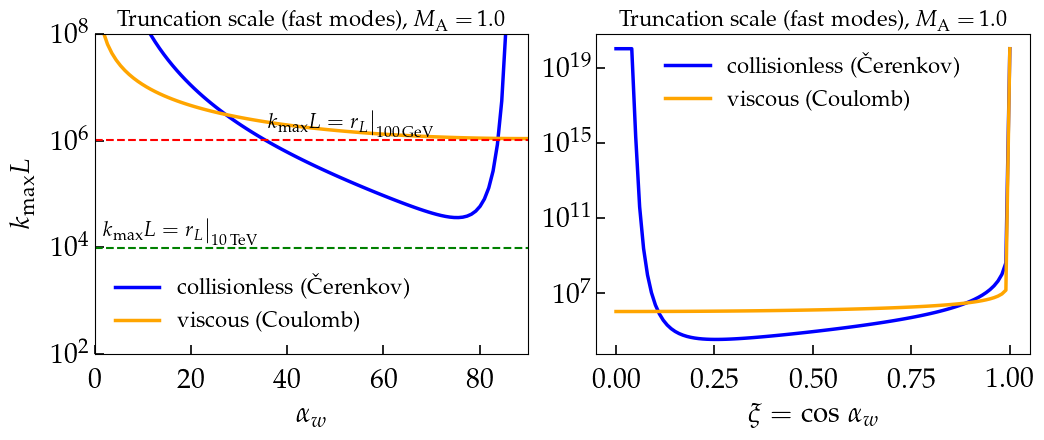

In [16]:
##################################################
### Calculate the truncation scale for damping ###
##################################################

import warnings
warnings.filterwarnings('ignore')
print('I am ignoring the warnings, due to the singularity of the functions.')
print('')

#max_kL = L_inj / Larmor_radius(1.e-2, B_field)[1]    # maximum kL, resonating with 10^{-2}GeV CRs
max_kL = 1e+20


# collisionless
def kmaxL_coll( alpha_ ):
    numerator = 4. * M_A**4 * gamma_ratio * ( np.cos( np.radians(alpha_) ) )**2
    denominator = np.pi * beta_plasma * ( np.sin( np.radians(alpha_) ) )**4
    exp = np.exp( 2. / ( beta_plasma * gamma_ratio * ( np.cos( np.radians(alpha_) ) )**2 ) )
    return numerator / denominator * exp

def kmaxL_coll_xi( cosAlpha_ ):
    numerator = 4. * M_A**4 * gamma_ratio * ( cosAlpha_ )**2
    denominator = np.pi * beta_plasma * ( 1 - cosAlpha_**2 )**2
    exp = np.exp( 2. / ( beta_plasma * gamma_ratio * ( cosAlpha_ )**2 ) )
    return min(max_kL, numerator / denominator * exp)


# collisional (viscous)
def kmaxL_visc( alpha_ ):
    return x_c * ( np.sin( np.radians(alpha_) ) )**(-4/3)

def kmaxL_visc_xi( cosAlpha_ ):
    return min(max_kL, x_c * ( 1 - cosAlpha_**2 )**(-2/3))



num_alpha = 101 #101
alpha = np.linspace(start = 0., stop = 90., num = num_alpha)    # wave pitch-angle in degrees
cosAlpha = np.linspace(start = 0., stop = 1., num = num_alpha)


plt.figure(figsize=(10.5, 4.5))
plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.plot(alpha, kmaxL_coll(alpha), lw=2.5, color='blue', label='collisionless (\\v{Cerenkov})')
plt.plot(alpha, kmaxL_visc(alpha), lw=2.5, color='orange', label='viscous (Coulomb)')
plt.axis([0.,90., 1.e2,1.e8])
plt.axhline(y=ell_inverse[indx_result_100GeV], ls='--', lw=1.5, color='red')
plt.axhline(y=ell_inverse[indx_result_10TeV], ls='--', lw=1.5, color='green')
plt.text(0.4, 0.703, '$k_{\mathrm{max}}L = r_L \\big|_{100 \, \mathrm{GeV}}$', fontsize=15, transform = plt.gca().transAxes)
plt.text(0.02, 0.366, '$k_{\mathrm{max}}L = r_L \\big|_{10 \, \mathrm{TeV}}$', fontsize=15, transform = plt.gca().transAxes)
plt.title('Truncation scale (fast modes), $M_{\mathrm{A}} = \,$' + str(M_A), fontsize=16, loc='center', pad=None)
plt.xlabel('$\\alpha_w$',fontsize=20)
plt.ylabel('$k_\mathrm{max}L$',fontsize=20)
plt.yscale('log')
plt.legend(fontsize=16, frameon=False, loc='best')


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.plot(cosAlpha, [kmaxL_coll_xi(i) for i in cosAlpha], lw=2.5, color='blue', label='collisionless (\\v{Cerenkov})')
plt.plot(cosAlpha, [kmaxL_visc_xi(i) for i in cosAlpha], lw=2.5, color='orange', label='viscous (Coulomb)')
plt.title('Truncation scale (fast modes), $M_{\mathrm{A}} = \,$' + str(M_A), fontsize=16, loc='center', pad=None)
plt.xlabel('$\\xi = \mathrm{cos} \; \\alpha_w$',fontsize=20)
plt.yscale('log')
plt.legend(fontsize=16, frameon=False, loc='best')
plt.tight_layout()


# <center> Resonance functions

## General expression
### Reference: [Yan & Lazarian, ApJ 673, 942 (2008)](https://ui.adsabs.harvard.edu/abs/2008ApJ...673..942Y/abstract "Open in ADS database")  

(note the factor 2 missing in YL08)

$$
\mathcal{R}_n \left( k_\parallel, \Omega \right) = \frac{\sqrt{\pi}}{\sqrt{2 M_\mathrm{A}} \, |k_\parallel| v_\perp} \cdot \mathrm{exp} \left[ { -\frac{ \left(k_\parallel v_\parallel - \omega \pm n\Omega \right)^2 }{2 M_\mathrm{A} k_\parallel^2 v_\perp^2 } } \right] 
\qquad\,\mathrm{with}\quad M_\mathrm{A}^2 \equiv \frac{ \left\langle\delta  B_\parallel^2\right\rangle }{B_0^2}
$$

## Relevant contributions and suitable formulation for each mode

### <u>Fast modes</u>: 
#### relevant contributions: $n=0,\pm1$  
#### suitable variables: ($x$, $\xi$) $\qquad\qquad$ [with $x=kL$ and $\xi=k_\|/k=\cos(\alpha_w)$]

$$
%\begin{aligned}
%&\mathcal{R}_n \left( k_\parallel, \Omega \right) = \frac{\sqrt{\pi}}{\sqrt{2} \, |k_\parallel| v_\perp \left( \frac{ \left\langle\delta  B_\parallel^2\right\rangle }{B_0^2} \right)^{1/4}} \cdot \mathrm{exp} \left[ { -\frac{ \left(k_\parallel v_\parallel - \omega \pm n\Omega \right)^2 }{2 k_\parallel^2 v_\perp^2 \left( \frac{ \left\langle\delta  B_\parallel^2\right\rangle }{B_0^2} \right)^{1/2} } } \right] =  
%\begin{cases}
%\mathcal{R}_0 = \frac{L \sqrt{\pi}}{\sqrt{2} x |\xi| v_{\mathrm{CR}} (1 - \mu^2)^{1/2} M_A^{1/2}} \cdot e^{ -\frac{\left( \mu \, - \, \frac{v_A}{\xi v_{\mathrm{CR}}} \right)^2}{2 (1 - \mu^2)M_A}  } & n=0\\[6pt]
%\mathcal{R}_{\pm 1} = \frac{L \sqrt{\pi}}{\sqrt{2} x |\xi| v_{\mathrm{CR}} (1 - \mu^2)^{1/2} M_A^{1/2}} \cdot e^{ -\frac{\left( \mu \, \pm \, \frac{1}{x \xi R} \right)^2}{2 (1 - \mu^2)M_A}  } & n=\pm 1
%&M_\mathrm{A}^2 \equiv \frac{ \left\langle\delta  B_\parallel^2\right\rangle }{B_0^2}
%\end{cases}\\[10pt]
%\end{aligned}
$$
$$
\mathcal{R}_0 = \frac{L \sqrt{\pi}}{\sqrt{2 M_\mathrm{A}} x |\xi| v_{\mathrm{CR}} (1 - \mu^2)^{1/2}} \cdot e^{ -\frac{\left( \mu \, - \, \frac{v_A}{\xi v_{\mathrm{CR}}} \right)^2}{2 M_\mathrm{A} (1 - \mu^2)}  } \qquad\,(n=0)
$$
$$
\mathcal{R}_{\pm 1} \simeq \frac{L \sqrt{\pi}}{\sqrt{2 M_\mathrm{A}} x |\xi| v_{\mathrm{CR}} (1 - \mu^2)^{1/2}} \cdot e^{ -\frac{\left( \mu \, \pm \, \frac{1}{x \xi R} \right)^2}{2 M_\mathrm{A} (1 - \mu^2)}  } \qquad\,(n=\pm 1)
$$
    
    
### <u>Alfvén modes</u>
#### relevant contributions: $n=\pm1$ 
#### suitable variables: ($x_\parallel$, $x_\perp$) $\qquad\qquad$ [with $x_\parallel=k_\parallel L$ and $x_\perp=k_\perp L$]
$$
\begin{aligned}
\mathcal{R}_{\pm 1}\simeq \frac{L \sqrt{\pi}}{\sqrt{2 M_\mathrm{A}} |x_\parallel| v_{\mathrm{CR}} (1 - \mu^2)^{1/2}} \cdot e^{ -\frac{\left( \mu \, \pm \, \frac{1}{x_\parallel R} \right)^2}{2 M_\mathrm{A} (1 - \mu^2)}  }
\end{aligned}
$$

## <center> Diffusion coefficient

### $D_{\mu \mu}$ for fast modes, TTD $(n=0)$

$$\begin{align}
D^{T}_{\mu \mu} \, \frac{L}{v_{\mathrm{CR}}} &= \frac{M_A^2 \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 \sqrt{2} R^2 M^{1/2}_A} \cdot \int^1_0 d \xi \int^{k_{\mathrm{max}}L(\xi)}_1 dx \, \xi \, J_1^2(\omega) \, x^{-5/2} e^{-\frac{ \left(\mu \, - \, \frac{v_A}{c \, \xi}\right)^2 }{2(1 - \mu^2) M_A} } \\[10pt]
&= \frac{4 \pi \, v_{\mathrm{CR}} (1 - \mu^2)}{L^{4}R^2} \cdot \int_0^1 d\xi \, \xi^2 \int_1^{k_{\mathrm{max}}L(\xi)} dx \, x^2 \, J_1^2(\omega) \, \mathcal{R}_0(\mu, \xi, x) \, I^{\mathrm{F}}_{\mathrm{norm}}(x) \\[10pt]
&\begin{cases}
&I^{\mathrm{F}}(x) = \frac{M_A^2 L^{-1/2}}{8\pi} \, k^{-7/2} \quad \rightarrow \quad I^{\mathrm{F}}_{\mathrm{norm}}(x) = \frac{M_A^2 L^{3}}{8\pi} \, (kL)^{-7/2} \\[6pt]
&\omega = R \, x \, (1 - \xi^2)^{1/2} (1 - \mu^2)^{1/2}, \quad R = \frac{r_L}{L}
\end{cases}
\end{align}$$

$$
$$
### $D_{\mu \mu}$ for fast modes, Gyro $(n \neq 0)$

$$
\left( D^{\mathrm{F,Gyro},\, n=1}_{\mu \mu} + D^{\mathrm{F,Gyro}, \, n=-1}_{\mu \mu} \right) \frac{L}{v_{\mathrm{CR}}} = \frac{4 \pi \, v_{\mathrm{CR}} (1 - \mu^2)}{L^{4}R^2} \cdot \int_0^1 d\xi \, \xi^2 \int_1^{k_{\mathrm{max}}L(\xi)} dx \, x^2 \, \left( \frac{J_0(\omega) - J_2(\omega)}{2} \right)^2 \, I^{\mathrm{F}}_{\mathrm{norm}}(x) \, \left\{ \mathcal{R}_{+1}(\mu, \xi, x, R) + \mathcal{R}_{-1}(\mu, \xi, x, R) \right\}
$$
    
    
### $D_{\mu \mu}$ for Alfvén modes, M_A < 1, Gyro $(n \neq 0)$
    
$$
\begin{align}
\left( D^{\mathrm{A,Gyro},\, n=1}_{\mu \mu} + D^{\mathrm{A,Gyro}, \, n=-1}_{\mu \mu} \right) \frac{L}{v_{\mathrm{CR}}} &= \frac{4 \pi \, v_{\mathrm{CR}} (1 - \mu^2)}{L^{4}R^2} \cdot \int_1^{\infty} dx_\parallel \int_{M_A^{-2}}^{\infty} dx_\perp \, x_\perp \frac{[J_1(\omega)]^2}{\omega^2} \, I^{\mathrm{A}}_{\mathrm{norm}}(x_\parallel, x_\perp) \, \left\{ \mathcal{R}_{+1}(\mu, x_\parallel, x_\perp, R) + \mathcal{R}_{-1}(\mu, x_\parallel, x_\perp, R) \right\} \\[10pt]
&\begin{cases}
&I^{\mathrm{A}}(x_\parallel, x_\perp) = \frac{M_A^{4/3} L^{-1/3}}{6\pi} \, k_\perp^{-10/3} \cdot e^{-\frac{L^{1/3} |k_\parallel|}{M_A^{4/3} k_\perp^{2/3}}} \quad \rightarrow \quad I^{\mathrm{A}}_{\mathrm{norm}}(x_\parallel, x_\perp) = \frac{M_A^{4/3} L^{3}}{6\pi} \, x_\perp^{-10/3} \cdot e^{-\frac{|x_\parallel|}{M_A^{4/3} x_\perp^{2/3}}} \\[6pt]
&\omega = R \, x_\perp (1 - \mu^2)^{1/2}, \quad R = \frac{r_L}{L}
\end{cases}
\end{align}
$$

In [17]:
## Define useful functions ##


# Resonance functions
def resonance_fast( x_, xi_, mu_, R_, n_ ):
    ctrl_z = 1e-16
    A = ( L_inj*pc_cm / ( c * x_ ) ) * np.sqrt( np.pi / ( 2. * M_A ) )
    z_ = np.abs(xi_) * np.sqrt(1 - mu_**2)
    
    if z_ <= ctrl_z:
        ff_ = 0.
    else:
        if n_ == 0:
            ff_ = A * np.exp( - ( (xi_*mu_ - v_A) / (np.sqrt(1. - mu_**2) * xi_ * c)  )**2 / ( 2. * M_A ) ) / z_
        else:
            ff_ = A * np.exp( - ( (xi_*mu_*x_*R_ + n_) / (np.sqrt(1. - mu_**2) * xi_*x_*R_) )**2 / ( 2. * M_A ) ) / z_
            
    return ff_



def resonance_alf( x_para_, mu_, R_, n_ ):
    ctrl_z = 1e-16
    A = ( L_inj*pc_cm / c ) * np.sqrt( np.pi / ( 2. * M_A ) )
    z_ = np.abs(x_para_) * np.sqrt(1 - mu_**2)
    
    if z_ <= ctrl_z:
        ff_ = 0.
    else:
        ff_ = A * np.exp( - ( (x_para_*mu_*R_ + n_) / (np.sqrt(1. - mu_**2) * x_para_*R_) )**2 / ( 2. * M_A ) ) / z_
            
    return ff_
     
    
    
# For the calculation of the D_mumu
def fast_spectrum_norm( x_ ):
    return M_A**2 * L_inj**3 / ( 8 * np.pi ) * x_**(-7./2.)

def alfven_spectrum_norm( x_para_, x_perp_ ):
    return M_A**(4./3.) * L_inj**3 / ( 6 * np.pi ) * x_perp_**(-10./3.) * np.exp( - np.abs(x_para_) / ( M_A**(4./3.) * x_perp_**(2./3.) ) )

def factor_Dmumu( mu_, R_ ):
    # it is the same for fast and alfvén modes
    return ( 4 * np.pi * c_pcSec * (1 - mu_**2) ) / ( L_inj**4 * R_**2 )

def Bessel_argFast( R_, x_, xi_, mu_ ):
    return R_ * x_ * np.sqrt(1 - xi_**2) * np.sqrt(1 - mu_**2)

def Bessel_argAlf( R_, x_perp_, mu_ ):
    return R_ * x_perp_ * np.sqrt(1 - mu_**2)


In [18]:
#case_region = 'Halo'
case_region = 'Disk'

In [ ]:
########################################
### Calculate the D(R) in the Disk #####
########################################

    
# Define the integration variables #
length_energy_array = 30 #60
length_mu_array = 101 #101  

p_CR = np.logspace(start = 0., stop = 5., num = length_energy_array)      # CR momentum, in [GeV/c]
R = Larmor_radius(p_CR, B_field)[1] / L_inj
mu_array = np.linspace(start = 0., stop = 0.999, num = length_mu_array)   # problems with 0° pitch-angle scattering
n_decades_alfvenModes = round( np.log10( max_kL ) )                       # number of decades in the Alfvénic cascade
pointsPerDecade = 10                                                      # for the integrals over the turbulence
xPara_array = np.logspace(start = 0., stop = np.log10( max_kL ), num = n_decades_alfvenModes * pointsPerDecade)
xPerp_array = np.logspace(start = np.log10( M_A**(-2.) ), stop = np.log10( max_kL ), num = n_decades_alfvenModes * pointsPerDecade)


integralOverX_TTD = np.zeros( len(cosAlpha) )
integralOverX_Gyro = np.zeros( len(cosAlpha) )
Dmumu_norm_fast = np.zeros( (len(R), len(mu_array)) )
Dmumu_norm_fast_TTD = np.zeros( (len(R), len(mu_array)) )
Dmumu_norm_fast_Gyro = np.zeros( (len(R), len(mu_array)) )
integralOverMu_Fast = np.zeros( len(R) )
integralOverMu_Alfven = np.zeros( len(R) )
integralOverMu_tot = np.zeros( len(R) )

integrandXperp = np.zeros( len(xPerp_array) )
integralOverXperp = np.zeros( len(xPara_array) )
Dmumu_norm_Alfven = np.zeros( (len(R), len(mu_array)) )


for indx_R, r in enumerate(tqdm(R)):
    print("Dmumu calculation for R =",r)
    
    for indx_mu, mu in enumerate(mu_array):
        
        ### Fast modes ###
        ##################
        for indx_csi, csi in enumerate(cosAlpha):
            
            if case_region == 'Halo':
                n_decades = round( np.log10( kmaxL_coll_xi(csi) ) )
                x_grid = np.logspace(start=0., stop=np.log10( kmaxL_coll_xi(csi) ), num=n_decades*pointsPerDecade)
            
            elif case_region == 'Disk':
                n_decades = round( np.log10( min( kmaxL_visc_xi(csi), kmaxL_coll_xi(csi) ) ) )
                x_grid = np.logspace(start=0., stop=np.log10( min( kmaxL_visc_xi(csi), kmaxL_coll_xi(csi) ) ), num=n_decades*pointsPerDecade)
            
            turbSpectrum = fast_spectrum_norm( x_grid )
            
            ## TTD (n=0)
            n_TTD = 0
            besselFuncTTD_squared = ( bessel.jv( 1, Bessel_argFast(r, x_grid, csi, mu) ) )**2
            resonanceFunc_TTD = resonance_fast( x_grid, csi, mu, r, n_TTD )
            integralOverX_TTD[indx_csi] = np.trapz( y = csi**2 * x_grid**2 * besselFuncTTD_squared * resonanceFunc_TTD * turbSpectrum, x = x_grid, axis=-1 )
            
            ## Gyro (n≠0)
            n_Gyro_plus1 = 1
            n_Gyro_minus1 = -1
            besselFuncGyro_squared = ( ( bessel.jv( 0, Bessel_argFast(r, x_grid, csi, mu) ) - bessel.jv( 2, Bessel_argFast(r, x_grid, csi, mu) ) ) / 2. )**2
            resonanceFunc_Gyro = resonance_fast( x_grid, csi, mu, r, n_Gyro_plus1 ) + resonance_fast( x_grid, csi, mu, r, n_Gyro_minus1 )
            integralOverX_Gyro[indx_csi] = np.trapz( y = csi**2 * x_grid**2 * besselFuncGyro_squared * resonanceFunc_Gyro * turbSpectrum, x = x_grid, axis=-1 )
            
            
        Dmumu_norm_fast[indx_R, indx_mu] = c_pcSec / L_inj * factor_Dmumu(mu, r) * np.trapz( y = integralOverX_TTD + integralOverX_Gyro, x = cosAlpha, axis=-1 )
        Dmumu_norm_fast_TTD[indx_R, indx_mu] = c_pcSec / L_inj * factor_Dmumu(mu, r) * np.trapz( y = integralOverX_TTD, x = cosAlpha, axis=-1 )
        Dmumu_norm_fast_Gyro[indx_R, indx_mu] = c_pcSec / L_inj * factor_Dmumu(mu, r) * np.trapz( y = integralOverX_Gyro, x = cosAlpha, axis=-1 )
        ##################
        
        
        ### Alfvén modes ###
        ####################
        for indx_xPara, x_para in enumerate(xPara_array):
            
            for indx_xPerp, x_perp in enumerate(xPerp_array):
            
                besselFuncAlfven_overW = ( bessel.jv( 1, Bessel_argAlf(r, x_perp, mu) ) / Bessel_argAlf(r, x_perp, mu) )**2
                resonanceFuncAlfven = resonance_alf( x_para, mu, r, n_Gyro_plus1 ) + resonance_alf( x_para, mu, r, n_Gyro_minus1 )
                turbSpectrumAlfven = alfven_spectrum_norm( x_para, x_perp )
                integrandXperp[indx_xPerp] = x_perp * besselFuncAlfven_overW * turbSpectrumAlfven * resonanceFuncAlfven
                
            integralOverXperp[indx_xPara] = np.trapz( y = integrandXperp, x = xPerp_array, axis=-1 )
            
        Dmumu_norm_Alfven[indx_R, indx_mu] = c_pcSec / L_inj * factor_Dmumu(mu, r) * np.trapz( y = integralOverXperp, x = xPara_array, axis=-1 )
        ####################
        
    

  0%|          | 0/30 [00:00<?, ?it/s]

Dmumu calculation for R = 1.07244e-08
Dmumu calculation for R = 1.5950958939458534e-08
Dmumu calculation for R = 2.372469239195593e-08
Dmumu calculation for R = 3.528697122406599e-08
Dmumu calculation for R = 5.2484151010120046e-08
Dmumu calculation for R = 7.806241260441292e-08
Dmumu calculation for R = 1.1610629388758913e-07
Dmumu calculation for R = 1.726909408837454e-07
Dmumu calculation for R = 2.5685223483393795e-07
Dmumu calculation for R = 3.8202971274330566e-07
Dmumu calculation for R = 5.682126982974903e-07
Dmumu calculation for R = 8.451323542037041e-07


### <center> Final Integral
    
$$D(R) = \frac{1}{4} \int_{0}^{1} d\mu \, \frac{v_{\mathrm{CR}}^2 \, (1 - \mu^2)^2}{D^{\mathrm{F,TTD}}_{\mu \mu}  + D^{\mathrm{F,Gyro}}_{\mu \mu} + D^{\mathrm{A,Gyro}}_{\mu \mu}}$$

In [ ]:
## Integration over the CR pitch angle ##

for ir in range( len(R) ):
    integralOverMu_Fast[ir] = 1./4. * np.trapz( y = c**2 * (1 - mu_array**2)**2 / Dmumu_norm_fast[ir,:], x = mu_array, axis=-1 )
    integralOverMu_Alfven[ir] = 1./4. * np.trapz( y = c**2 * (1 - mu_array**2)**2 / Dmumu_norm_Alfven[ir,:], x = mu_array, axis=-1 )
    integralOverMu_tot[ir] = 1./4. * np.trapz( y = c**2 * (1 - mu_array**2)**2 / ( Dmumu_norm_fast[ir,:] + Dmumu_norm_Alfven[ir,:] ), x = mu_array, axis=-1 )
    

In [ ]:
## Plotting the D(E) ##

print(f'The D(E) is computed in the {case_region}.')
print('')
print(f'energy points: {len(R)}')
print(f'number of points/decade in x: {pointsPerDecade}')
print(f'N_xi = {len(cosAlpha)}, xi array: [{cosAlpha[0]} -> {cosAlpha[-1]}]')
print(f'N_mu = {len(mu_array)}, mu array: [{mu_array[0]} -> {mu_array[-1]}]')


# Plotting D(E) from Alfvén modes #
###################################
plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.loglog(R, integralOverMu_Alfven, lw=2.5, color='blue')
plt.title('Alfvén modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ R \equiv r_L \\big/L$',fontsize=20)
plt.ylabel('$D(E) \, [\mathrm{cm^2 \cdot s^{-1}}]$',fontsize=20)
plt.text(0.85, 0.05, str(case_region), fontsize=17, transform = plt.gca().transAxes)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.loglog( LarmorToMomentum(R * (L_inj*pc_cm), B_field), integralOverMu_Alfven, lw=2.5, color='blue')
plt.title('Alfvén modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ E \, [\mathrm{GeV}]$',fontsize=20)
plt.text(0.05, 0.9, '$B = \,$' + str("{:.1f}".format(B_field)) + '$\, \mu \mathrm{G}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.8, '$M_\mathrm{A} = \,$' + str("{:.0f}".format(M_A)), fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.7, '$L_\mathrm{inj} = \,$' + str("{:.0f}".format(L_inj)) + '$\, \mathrm{pc}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.6, '$n_\mathrm{ISM} = \,$' + str("{:.1f}".format(n_ISM)) + '$\, \mathrm{cm^{-3}}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.5, '$T_\mathrm{ISM} = \,$' + str("{:.0f}".format(T_ISM)) + '$\, \mathrm{K}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.4, '$\\beta_{\mathrm{plasma}} = \,$' + str("{:.3f}".format(beta_plasma)), fontsize=17, transform = plt.gca().transAxes)
plt.text(0.85, 0.05, str(case_region), fontsize=17, transform = plt.gca().transAxes)
plt.tight_layout()
###################################


# Plotting D(E) from fast modes #
#################################
plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.loglog(R, integralOverMu_Fast, lw=2.5, color='blue')
plt.title('Fast modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ R \equiv r_L \\big/L$',fontsize=20)
plt.ylabel('$D(E) \, [\mathrm{cm^2 \cdot s^{-1}}]$',fontsize=20)
plt.text(0.85, 0.05, str(case_region), fontsize=17, transform = plt.gca().transAxes)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.loglog( LarmorToMomentum(R * (L_inj*pc_cm), B_field), integralOverMu_Fast, lw=2.5, color='blue')
plt.title('Fast modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ E \, [\mathrm{GeV}]$',fontsize=20)
plt.text(0.05, 0.9, '$B = \,$' + str("{:.1f}".format(B_field)) + '$\, \mu \mathrm{G}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.8, '$M_\mathrm{A} = \,$' + str("{:.0f}".format(M_A)), fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.7, '$L_\mathrm{inj} = \,$' + str("{:.0f}".format(L_inj)) + '$\, \mathrm{pc}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.6, '$n_\mathrm{ISM} = \,$' + str("{:.1f}".format(n_ISM)) + '$\, \mathrm{cm^{-3}}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.5, '$T_\mathrm{ISM} = \,$' + str("{:.0f}".format(T_ISM)) + '$\, \mathrm{K}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.4, '$\\beta_{\mathrm{plasma}} = \,$' + str("{:.3f}".format(beta_plasma)), fontsize=17, transform = plt.gca().transAxes)
plt.text(0.85, 0.05, str(case_region), fontsize=17, transform = plt.gca().transAxes)
plt.tight_layout()
#################################



# Plotting D(E) from ALL modes #
################################
plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()


plt.loglog(R, integralOverMu_tot, lw=2.5, color='blue')
plt.title('Fast+Alfvén modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ R \equiv r_L \\big/L$',fontsize=20)
plt.ylabel('$D(E) \, [\mathrm{cm^2 \cdot s^{-1}}]$',fontsize=20)
plt.text(0.85, 0.05, str(case_region), fontsize=17, transform = plt.gca().transAxes)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.loglog( LarmorToMomentum(R * (L_inj*pc_cm), B_field), integralOverMu_tot, lw=2.5, color='blue')
plt.title('Fast+Alfvén modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ E \, [\mathrm{GeV}]$',fontsize=20)
plt.text(0.05, 0.9, '$B = \,$' + str("{:.1f}".format(B_field)) + '$\, \mu \mathrm{G}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.8, '$M_\mathrm{A} = \,$' + str("{:.0f}".format(M_A)), fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.7, '$L_\mathrm{inj} = \,$' + str("{:.0f}".format(L_inj)) + '$\, \mathrm{pc}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.6, '$n_\mathrm{ISM} = \,$' + str("{:.1f}".format(n_ISM)) + '$\, \mathrm{cm^{-3}}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.5, '$T_\mathrm{ISM} = \,$' + str("{:.0f}".format(T_ISM)) + '$\, \mathrm{K}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.4, '$\\beta_{\mathrm{plasma}} = \,$' + str("{:.3f}".format(beta_plasma)), fontsize=17, transform = plt.gca().transAxes)
plt.text(0.85, 0.05, str(case_region), fontsize=17, transform = plt.gca().transAxes)
plt.tight_layout()
################################


In [ ]:
## Plotting the D_mumu ##


selected_p = [10., 100., 1.e4]
colors = ['blue', 'red', 'green', 'orange']
labels = [str(p) + '$\, \mathrm{GeV}$' for p in selected_p]
selected_R = [Larmor_radius(p, B_field)[1] / L_inj for p in selected_p]
indx_selR = [np.argmin( abs( ir - R ) ) for ir in selected_R]


plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

for indx_r, r in enumerate(indx_selR):
    plt.plot(mu_array, L_inj / c_pcSec * Dmumu_norm_fast_TTD[r, :], lw=2., ls='-', color=colors[indx_r], label=labels[indx_r])
    plt.plot(mu_array, L_inj / c_pcSec * Dmumu_norm_fast_Gyro[r, :], lw=2., ls='--', color=colors[indx_r])
    
plt.title('Fast modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ \\mu $',fontsize=20)
plt.ylabel('$ D_{\\mu \\mu} \cdot L\\big/c $',fontsize=20)
plt.legend(frameon=False, fontsize=15)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

for indx_r, r in enumerate(indx_selR):
    plt.plot(mu_array, L_inj / c_pcSec * Dmumu_norm_Alfven[r, :], lw=2., ls='-', color=colors[indx_r], label=labels[indx_r])

plt.title('Alfvén modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ \\mu $',fontsize=20)
plt.ylabel('$ D_{\\mu \\mu} \cdot L\\big/c $',fontsize=20)
plt.yscale('log')
plt.legend(frameon=False, fontsize=15)
plt.tight_layout()


In [ ]:
### Block to store the output D(R) in a text file ###

print(len(p_CR), len(R), len(integralOverMu_tot))
print('')

data_for_text_file = np.zeros( (len(p_CR), 3) )

data_for_text_file[:,0] = p_CR
data_for_text_file[:,1] = R
data_for_text_file[:,2] = integralOverMu_tot

print(data_for_text_file)

txt_file_name = 'DiffCoeff_MHD' + str(L_inj) + '_MA' + str(M_A) + '_Bfield' + str(B_field) + '.txt'
np.savetxt(path_plots + 'TextFiles/' + txt_file_name, data_for_text_file)